# Explore extracted BETA-Features based on SSD

### 0) Load packages and functions

In [ ]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from itertools import compress, product
import pandas as pd
import numpy as np

import sklearn as sk
from scipy import signal, stats

import matplotlib.pyplot as plt



In [ ]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [ ]:
# define local storage directories
projectpath = get_project_path_in_notebook()
codepath = os.path.join(projectpath, 'code')
figpath = os.path.join(projectpath, 'figures')
datapath = os.path.join(projectpath, 'data')
feat_path = os.path.join(projectpath, 'results', 'features')

In [509]:
os.chdir(codepath)
# own utility functions
import utils.utils_fileManagement as utilsFiles
import utils.utils_windowing as utilsWindows
from utils.utils_fileManagement import (get_project_path,
                                        load_class_pickle,
                                        save_class_pickle,
                                        mergedData,
                                        correct_acc_class)
# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng
# own data exploration functions
import lfpecog_features.get_ssd_data as ssd

import lfpecog_plotting.phase_plotting as phasePlot



import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_analysis.import_ephys_results as importResults

import lfpecog_analysis.load_SSD_features as load_ssdFts
import lfpecog_features.feats_phases as phaseFts

import lfpecog_analysis.get_acc_task_derivs as importAcc


from lfpecog_plotting.plotHelpers import remove_duplicate_legend

### 1a) Define settings and Load Features and Acc-data

In [ ]:
SETTINGS = utilsFiles.load_ft_ext_cfg(cfg_fname='ftExtr_spectral_v1.json')

ssd_ft_path = os.path.join(feat_path, 'SSD_feats',
                           SETTINGS['DATA_VERSION'],
                           f"windows_{SETTINGS['WIN_LEN_sec']}s_"
                           f"{SETTINGS['WIN_OVERLAP_part']}overlap")
IGNORE_PTS = ['010', '011']  # 011 did not start in OFF, 010: check ECoG

SUBS_STUN_EFFECT = ['009', '014', '016']

In [ ]:
# get all available subs with features 
SUBS = list(set([name.split('_')[1] for name in os.listdir(ssd_ft_path)]))

for sub in IGNORE_PTS:
    if sub in SUBS: SUBS.remove(sub)

Load SSD-features

In [ ]:
importlib.reload(load_ssdFts)
importlib.reload(phaseFts)

# load all SSDd features
fts = load_ssdFts.ssdFeatures()

Load acc and task-labels

In [ ]:
importlib.reload(importAcc)
accs, labels = {}, {}
for sub in fts.sub_list:
    print(f'start sub {sub}')
    accs[sub], labels[sub] = importAcc.load_acc_and_task(sub=sub, dataversion='v3.0',
                                                resample_freq=500)

### 1b) Load Clinical Scores and define OFF vs ON

OFF definition:
    
    - up to 15 minutes after L-Dopa intake (max. dopa_time is 15)
    
    - no CDRS in total (max. CDRS total is 0)

    
ON definition:
    
    - at least 45 minutes after L-Dopa intake (min. dopa time is 45)
    
    - no severe Dyskinesia (max CDRS total is 5)


Stun-effect: sub-analysis on patients with significant OFF-reduction after OR versus pre-operative

In [ ]:
find_task_during_time(310000,
                      labels['009']['task'].values,
                      labels['009'].index.values)    

In [547]:
def define_OFF_ON_times(
    feat_times, cdrs_scores, cdrs_times,
    max_OFF_minutes=15,
    max_OFF_cdrs=0,
    min_ON_minutes=45,
    max_ON_CDRS=5,
    incl_tasks='all',
    labels_df=None
):
    if isinstance(feat_times, list): feat_times = np.array(feat_times)
    # ensure all times are in minutes
    if np.nanmax(feat_times) > 200:
        feat_times /= 60
    if np.nanmax(cdrs_times) > 200:
        cdrs_times /= 60
    
    # get closest cdrs score for every feat-time
    ftwin_cdrs_score = [cdrs_scores[np.argmin(abs(cdrs_times - t))]
                        for t in feat_times]
    
    off_times_sel = [np.logical_and(m < max_OFF_minutes,
                                    ftwin_cdrs_score[i] == max_OFF_cdrs)
                     for i, m in enumerate(feat_times)]
    
    on_times_sel = [np.logical_and(m > min_ON_minutes,
                                   ftwin_cdrs_score[i] <= max_ON_CDRS)
                     for i, m in enumerate(feat_times)]
    
    # perform selection on task
    if incl_tasks != 'all':
        task_sel = importAcc.select_task_in_features(
            ft_times=feat_times, label_df=labels_df,
            task=incl_tasks)
        # combine selection on on/off moments and included tasks
        off_times_sel = np.logical_and(off_times_sel, task_sel)
        on_times_sel = np.logical_and(on_times_sel, task_sel)
    
    return off_times_sel, on_times_sel


get individual OFF and ON selection

In [ ]:
import lfpecog_analysis.get_acc_task_derivs as importAcc

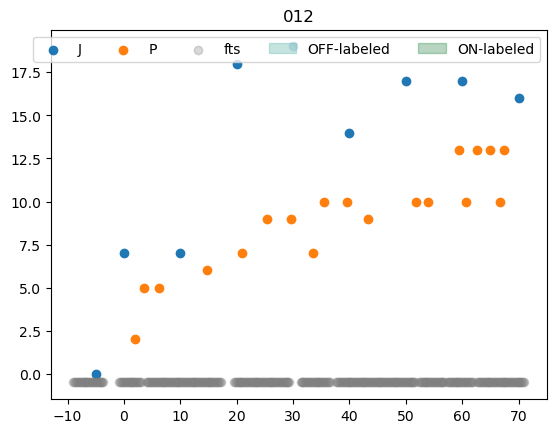

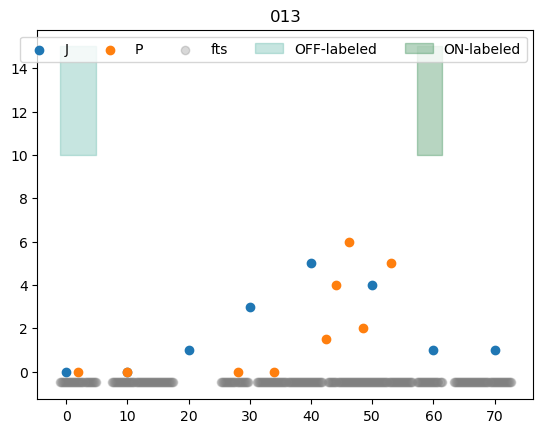

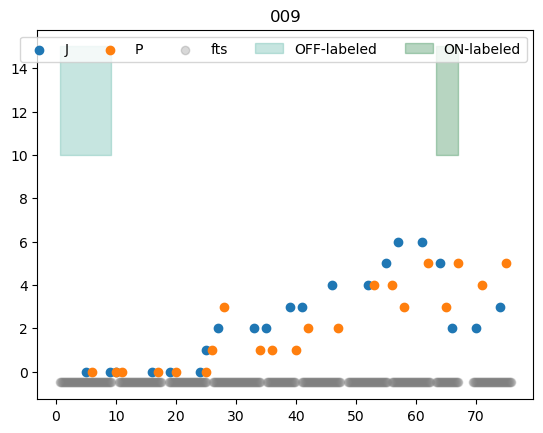

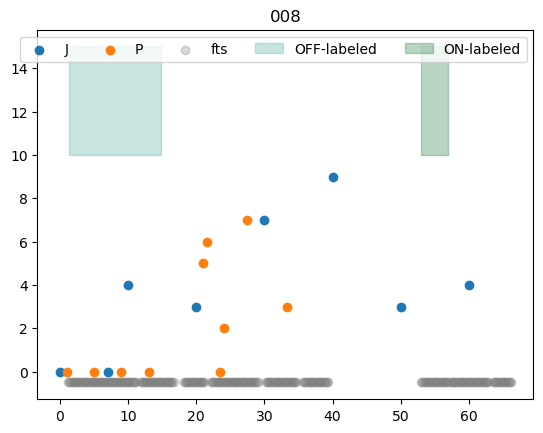

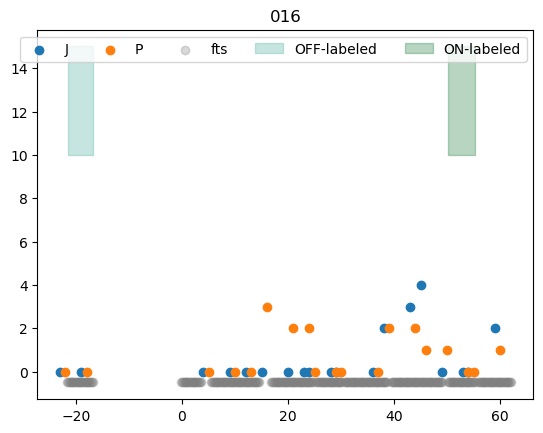

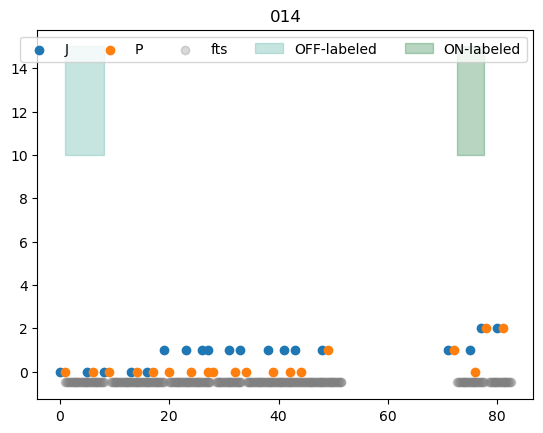

In [510]:
importlib.reload(importAcc)

INCL_TASKS = ['rest']
SHOW_MED_SELECTION = True

med_state_select = {}

for sub in SUBS:
    
    med_state_select[sub] = {'OFF': {}, 'ON': {}}
    cdrss = {}
    for rater in ['Patricia', 'Jeroen']:
        cdrss[rater[0]] = importClin.read_clinical_scores(sub=sub, rater=rater)

    sub_ft_times = getattr(fts, f'sub{sub}').powers.index.values.copy()
    if np.nanmax(sub_ft_times) > 200:
        sub_ft_times /= 60  # feature window times in minutes

    sub_cdrs_minutes = getattr(fts, f'sub{sub}').scores.times.copy()
    sub_cdrs_totals = getattr(fts, f'sub{sub}').scores.total.copy()

    off_sel, on_sel = define_OFF_ON_times(
        feat_times=getattr(fts, f'sub{sub}').powers.index.values.copy(),
        cdrs_scores=getattr(fts, f'sub{sub}').scores.total.copy(),
        cdrs_times=getattr(fts, f'sub{sub}').scores.times.copy(),
        min_ON_minutes=50,
        incl_tasks=INCL_TASKS,
        labels_df=labels[sub]
    )
    med_state_select[sub]['OFF'] = off_sel
    med_state_select[sub]['ON'] = on_sel
    
    if SHOW_MED_SELECTION:
        for r, rater in enumerate(['J', 'P']):  
            plt.scatter(cdrss[rater]['dopa_time'] + (1*r),
                        cdrss[rater]['CDRS_total'],
                        label=rater)

        plt.scatter(sub_ft_times, [-.5] * len(sub_ft_times),
                    color='gray', alpha=.3, label='fts')
        
        plt.fill_between(x=sub_ft_times, where=off_sel,
                        y1=10, y2=15,
                        label='OFF-labeled',
                        color=pltHelp.get_colors()['turquoise'], alpha=.3,)
        
        plt.fill_between(x=sub_ft_times, where=on_sel,
                        y1=10, y2=15,
                        label='ON-labeled',
                        color=pltHelp.get_colors()['darkgreen'], alpha=.3,)

        plt.title(sub)
        plt.legend(ncol=5)
        plt.show()

In [ ]:
# fts.sub011.coherences.STN_STN.hi_beta.imag_coh

### 1c) Select Features 

In [508]:
vars(fts.sub013).keys()

dict_keys(['sub', 'feat_path', 'settings', 'extract_settings', 'verbose', 'scores', 'powers', 'localPAC', 'coherences'])

In [ ]:
# getattr(fts, f'sub{sub}').coherences.STN_ECOG.hi_beta.imag_coh.index.values

In [ ]:
coh_values = getattr(fts, f'sub{sub}').coherences.STN_ECOG.hi_beta.imag_coh

plt.imshow(coh_values.T)
xticks = np.linspace(0, coh_values.shape[0]-1, 5).astype(int)
plt.xticks(xticks,
           labels=coh_values.index.values[xticks])
yticks = np.linspace(0, coh_values.shape[1]-1, 5).astype(int)
plt.yticks(yticks,
           labels=coh_values.index.values[yticks])
plt.gca().invert_yaxis()

plt.show()

In [ ]:
coh_values = getattr(fts, f'sub{sub}').coherences.STN_ECOG.hi_beta.imag_coh.copy()
plt.plot(
    coh_values.index,
    coh_values.mean(axis=1)
)

In [ ]:
sub = '008'

# show coherences

off_values = []
on_values = []

sub_coh_values = getattr(fts, f'sub{sub}').coherences

coh_df = sub_coh_values.STN_ECOG.lo_beta.sq_coh.copy()
coh_values = coh_df.mean(axis=1)
coh_times = coh_df.index

off_sel, on_sel = define_OFF_ON_times(
    feat_times=coh_times,
    cdrs_scores=getattr(fts, f'sub{sub}').scores.total.copy(),
    cdrs_times=getattr(fts, f'sub{sub}').scores.times.copy()     
)

off_values = coh_values.values[off_sel]
on_values = coh_values.values[on_sel]

plt.boxplot([off_values, on_values])
plt.show()



In [592]:
# TODO: save out figures to OneDrive

importlib.reload(phasePlot)
fsize=14
PAC_METRIC = 'mean'

for sub in SUBS:


    for i_t, TASK in enumerate(['rest', 'tap']):
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        # show PACs
        off_values = []
        on_values = []

        sub_pac_values = getattr(fts, f'sub{sub}').localPAC

        ecog_side = importClin.get_ecog_side(sub)
        src = f'ecog_{ecog_side}'
        # src = 'lfp_right'
        bw = 'hi_beta_broad_gamma'
        pac_sel = sub_pac_values[f'{src}_{bw}']

        if PAC_METRIC == 'mean':
            pac_summary = pac_sel.values.mean(axis=0).mean(axis=0)
        elif PAC_METRIC == 'max':
            pac_summary = pac_sel.values.max(axis=0).max(axis=0)

        pac_arr = pac_sel.values.copy()
        pac_times = pac_sel.times.copy()

        off_sel, on_sel = define_OFF_ON_times(
            feat_times=pac_times,
            cdrs_scores=getattr(fts, f'sub{sub}').scores.total.copy(),
            cdrs_times=getattr(fts, f'sub{sub}').scores.times.copy(),
            incl_tasks=TASK,
            labels_df=labels[sub],
        )
        if sum(off_sel) == 0 and sum(on_sel) == 0:
            plt.close()
            print(f'sub {sub} skipped, no data OFF and ON for {TASK}')
            continue

        # off_values = pac_summary[off_sel]
        # on_values = pac_summary[on_sel]

        # plt.boxplot([off_values, on_values])
        # plt.show()



        off_pac = np.nanmean(pac_arr[:, :, off_sel], axis=-1)
        on_pac = np.nanmean(pac_arr[:, :, on_sel], axis=-1)
        sub_max_pac = np.nanmax([np.nanmax(off_pac), np.nanmax(on_pac)])

        axes[0] = phasePlot.plot_pac_comodulogram(
            pac_arr_2d=off_pac,
            pha_bin_tuples=pac_sel.pha_bins,
            amp_bin_tuples=pac_sel.amp_bins,
            plot_title=f'OFF ({TASK})',
            plot_on_ax=axes[0],
            fig_axis=fig,
            vmax=sub_max_pac)
        axes[1] = phasePlot.plot_pac_comodulogram(
            pac_arr_2d=on_pac,
            pha_bin_tuples=pac_sel.pha_bins,
            amp_bin_tuples=pac_sel.amp_bins,
            plot_title=f'ON ({TASK})',
            plot_on_ax=axes[1],
            fig_axis=fig,
            vmax=sub_max_pac)
        
        plt.suptitle(f'PAC - sub {sub} ({bw}, in {src})',
                    size=fsize, color='darkgray',
                    x=.5, y=.99, ha='center',
                    weight='bold')
        plt.close()


sub 012 skipped, no data OFF and ON for rest
sub 012 skipped, no data OFF and ON for tap


C:\Users\habetsj\AppData\Local\Temp\ipykernel_20776\3159632562.py:52: RuntimeWarning: Mean of empty slice
  off_pac = np.nanmean(pac_arr[:, :, off_sel], axis=-1)
C:\Users\habetsj\AppData\Local\Temp\ipykernel_20776\3159632562.py:54: RuntimeWarning: All-NaN slice encountered
  sub_max_pac = np.nanmax([np.nanmax(off_pac), np.nanmax(on_pac)])


#### 1d) Extract burst-features

In [539]:
importlib.reload(ssd)

# try to call from feats_extract_multivar.py
for sub in SUBS:
    if sub != '014': continue
    print(f'start {sub}')
    ssd_dat = ssd.get_subject_SSDs(
        sub=sub, incl_stn=True,
        ft_setting_fname='ftExtr_spectral_v1.json',)

start 014
	...loaded SSD windowed-data and meta-info for ecog_right of sub-014
	...loaded SSD windowed-data and meta-info for lfp_left of sub-014
	...loaded SSD windowed-data and meta-info for lfp_right of sub-014


In [523]:
from scipy.signal import hilbert

In [530]:
importlib.reload(utilsFiles)

<module 'utils.utils_fileManagement' from 'c:\\Users\\habetsj\\Research\\projects\\dyskinesia_neurophys\\code\\utils\\utils_fileManagement.py'>

In [533]:
utilsFiles.get_beta_project_path('data')

True

336

In [580]:
sub = '014'
win_sel = {}
win_sel['off'], win_sel['on'] = define_OFF_ON_times(
    feat_times=ssd_dat.lfp_left.times.copy(),
    cdrs_scores=getattr(fts, f'sub{sub}').scores.total.copy(),
    cdrs_times=getattr(fts, f'sub{sub}').scores.times.copy(),
    min_ON_minutes=50,
    incl_tasks=INCL_TASKS,
    labels_df=labels[sub]
)



In [601]:
# TODO: include json dumping of threshold values
# incorporate in burst workflow

fig_dir = utilsFiles.get_beta_project_path('figures')

beta_ssd = {}
ecog_side = importClin.get_ecog_side(sub)

for f in ['lo', 'hi']:
    fig_fname = f'{sub}_{f.upper()}_BETA_burst_75percentiles'
    
    fig, axes = plt.subplots(1, 3, figsize=(8, 4))

    for i_src, src in enumerate(
        ['lfp_left', 'lfp_right', f'ecog_{ecog_side}']
    ):

        beta_ssd = getattr(ssd_dat, src)
        beta_ssd = getattr(beta_ssd, f'{f}_beta').copy()

        beta_env = abs(hilbert(beta_ssd))

        for cond in ['off', 'on']:

            env = beta_env[win_sel[cond]]

            percs = []

            for w in np.arange(sum(win_sel[cond])):
                thrs = np.nanpercentile(env[w], 75)
                percs.append(thrs)



            axes[i_src].hist(percs, alpha=.5,
                    label=f'{cond.upper()}, mean: '
                    f'{np.nanmean(percs).round(3)}')
            
        axes[i_src].set_xlabel("75-percentile (SSD'd envelop)")
        axes[i_src].set_ylabel('# observations (windows)')
        axes[i_src].legend()
        axes[i_src].set_title(f'{src}')

    plt.suptitle(f'sub {sub} - 75-percentile of {f} beta-envelope',
                 weight='bold',)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, fig_fname), dpi=150,
                facecolor='w')
    plt.close()

c:\Users\habetsj\Anaconda3\envs\ecog_dysk\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


In [602]:


# plt.plot(lo_beta_off[10], label='lo-B')
# plt.plot(hi_beta_off[10], label='hi-B')
# plt.legend()
# plt.xlim(0, 5000)
# plt.show()

# plt.plot(lo_beta_on[10], label='lo-B')
# plt.plot(hi_beta_on[10], label='hi-B')
# plt.legend()
# plt.xlim(0, 5000)
# plt.show()

### 2) Explore

In [ ]:
import lfpecog_plotting.plotHelpers as pltHelp
# pltHelp.get_colors()

In [ ]:
X_total = []
y_total_binary = []
y_total_scale = []
sub_ids_total = []
ft_times_total = []

EXCL_CODE = 99

TO_PLOT = False

if TO_PLOT:
    fig, axes = plt.subplots(len(SUBS), 1, figsize=(12, 16))
    fs = 16


for i_s, sub in enumerate(SUBS):
    # create lists to store values for boxplotting
    bp_LID_values_list = []
    bp_noLID_values_list = []
    bp_keys = []


    ### Create Y-labels based on CDRS (FT_LABELS)
    no_LID_sel = np.array(FT_LABELS[sub]) == 0
    LID_sel = np.array(FT_LABELS[sub]) >= LID_SCORE_INCL

    # create binary y-labels
    sub_y_bin = []  # y as binary
    for noLID, LID in zip(no_LID_sel, LID_sel):
        if noLID: sub_y_bin.append(0)
        elif LID: sub_y_bin.append(1)
        else: sub_y_bin.append(EXCL_CODE)
    # add full scaled y-labels
    sub_y_scale = FT_LABELS[sub]

    # append sub-codes to sub-id list
    sub_ids_total.append([sub] * FEATS[sub].shape[0])  # add subject code, as many times as there are feature rows

    # add subjects ft-times to list
    ft_times_total.append(FEATS[sub].index.values)

    ### Create X with standardised Feature-arrays
    sub_X = np.zeros_like((FEATS[sub]))

    for n_col, ft in enumerate(FEATS[sub].keys()):
        values = FEATS[sub].values[:, n_col]
        # split values on Dyskinesia
        noLID_values = values[no_LID_sel]
        LID_values = values[LID_sel]
        
        # define mean and std of no-LID for Z-SCORE
        m = np.nanmean(noLID_values)
        sd = np.nanstd(noLID_values)
        # Z-SCORE values
        Z_LID_values = (LID_values - m) / sd
        Z_noLID_values = (noLID_values - m) / sd
        Z_ALL_values = (values - m) / sd

        # add feat and z-score values to lists for BOXPLOT (WITHOUT NaNs)
        bp_LID_values_list.append(list(Z_LID_values[~np.isnan(LID_values)]))
        bp_keys.append(ft)

        # store all feats for pred-exploration
        sub_X[:, n_col] = Z_ALL_values
    
    X_total.append(sub_X)
    y_total_binary.append(sub_y_bin)
    y_total_scale.append(sub_y_scale)

    if TO_PLOT:
        ##### PLOT BOXPLOT OF FEATURES ######
        box = axes[i_s].boxplot(bp_LID_values_list)
        plt.setp(box['fliers'], color='gray')
        # plt.setp(box['whiskers'], color='red')

        axes[i_s].axhline(y=0, xmin=0, xmax=24, color='k', alpha=.3)
        for y_line in [-2, 2]: axes[i_s].axhline(y=y_line, xmin=0, xmax=24, color='r', alpha=.3)

        axes[i_s].set_ylim(-6, 6)
        axes[i_s].set_ylabel(f'z-scores\nvs no-LID (a.u.)', fontsize=fs)
        axes[i_s].set_title(f'Sub-{sub} (mean unilat. CDRS '
                            f'{round(np.mean(FT_LABELS[sub]), 2)})',
                            weight='bold', fontsize=fs)
        axes[i_s].set_xticklabels(['mx', 'mn', 'cv'] * int(len(bp_keys) / 3),
                                fontsize=fs,)

        for side in ['top','right','bottom']:
            axes[i_s].spines[side].set_visible(False)

        ### fill colors
        colors = {
            'alpha': 'yellow',
            'lo_beta': 'lightblue',
            'hi_beta': 'darkblue',
            'midgamma': 'green'
        }
        hatches = {
            'STN': '',
            'ECoG': '//'
        }

        x_fill_list = []
        for x1 in np.arange(.5, len(bp_keys) + .5, 3):
            x2 = x1 + 3
            x_fill_list.append([x1, x2])

        for i_x, (src, bw) in  enumerate(product(hatches.keys(), colors.keys())):
            axes[i_s].fill_betweenx(
                y=np.arange(-6, 6), x1=x_fill_list[i_x][0],
                x2=x_fill_list[i_x][1], color=colors[bw], hatch=hatches[src],
                label=f'{src} {bw}', alpha=.2, edgecolor='gray',)
if TO_PLOT:
    leg_content = plt.gca().get_legend_handles_labels()
    handles, labels = pltHelp.remove_duplicate_legend(leg_content)
    plt.legend(handles, labels, ncol=4, frameon=False,
            loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False,
            prop={'weight': 'bold', 'size': fs})

    plt.suptitle('Individual Feature values during Dyskinesia\n', weight='bold', fontsize=fs+4)
    plt.tight_layout()

    figname = 'LID_ssdFeatures_boxplots_indiv'
    # plt.savefig(os.path.join(figpath, 'ft_exploration', 'SSD', figname),
    #             dpi=300, facecolor='w',)
    plt.close()

print(f'FEATURES X-AXIS: {bp_keys}')
